<a href="https://colab.research.google.com/github/kyle-gao/GRSS_TrackMSD2021/blob/main/vgg16_fcn8_512.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import shutil
import os
from PIL import Image

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [37]:
vgg_16 = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(512,512,3))
vgg_16.trainable=True

In [5]:
vgg_16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [11]:
num_classes = 7

#FCN8
architecture from Supervised Classification of Multisensor Remotely
Sensed Images Using a Deep Learning Framework
Sankaranarayanan Piramanayagam 1,*, Eli Saber 1,2, Wade Schwartzkopf 3,†
and Frederick W. Koehler

code by me

image.png

In [38]:
def make_fcn8(input_size = (512,512,3), drop_rate = 0.1):
  input = tf.keras.layers.Input(shape=input_size)
  
  feature_layers = [ vgg_16.get_layer('block3_conv3'), vgg_16.get_layer('block4_conv3'), vgg_16.get_layer('block5_conv3')]
  conv_extractor = tf.keras.models.Model(inputs = vgg_16.input, outputs = [layer.output for layer in feature_layers])
  #w = image width
  #conv_extractor returns list of [(w/4,w/4,256),(w/8,w/8,512),(w/16,w/16,512)] tensors

  """dont do this:
    b3c3_model = Model(inputs=vgg_model.input, outputs = vgg_model.get_layer('block3_conv3').output)
    b3c3_model.trainable=False

    b2c2_model = Model(inputs=vgg_model.input, outputs = vgg_model.get_layer('block2_conv2').output)
    b2c2_model.trainable=False

    b1c2_model = Model(inputs=vgg_model.input, outputs = vgg_model.get_layer('block1_conv2').output)
    b1c2_model.trainable=False"""

  regularizer = tf.keras.regularizers.L1(l1=1e-4)
  features = conv_extractor(input)
  
  x3 = features[0]
  x3 = tf.keras.layers.Dropout(0,name='features_c3')(x3)
  x3 = tf.keras.layers.MaxPool2D()(x3)
  x3 = tf.keras.layers.Conv2D(num_classes, kernel_size = 1, activation = 'relu', padding = 'same', kernel_regularizer=regularizer)(x3)
  x3 = tf.keras.layers.Dropout(drop_rate)(x3)
  #(w/4,w/4,num_classes)


  x4 = features[1] #w/8
  x4 = tf.keras.layers.Dropout(0,name='features_c4')(x4)
  x4 = tf.keras.layers.MaxPool2D()(x4)
  x4 = tf.keras.layers.Conv2D(num_classes, kernel_size = 1, activation = 'relu', padding = 'same',kernel_regularizer=regularizer)(x4)
  x4 = tf.keras.layers.Dropout(drop_rate)(x4)
  #(w/8,w/8,num_classes)

  x5 = features[2] #w/16
  x5 = tf.keras.layers.Dropout(0,name='features_c5')(x5)

  #block6
  x = tf.keras.layers.MaxPool2D()(x5)
  x = tf.keras.layers.Conv2D(4096, kernel_size = 7, activation = 'relu', padding='same', kernel_regularizer=regularizer)(x)
  #x = tf.keras.layers.Conv2D(4096, kernel_size = 1, activation = 'relu', padding='same')(x)
  x = tf.keras.layers.Dropout(drop_rate)(x)

  #block7
  x = tf.keras.layers.Conv2D(4096, kernel_size = 1, activation = 'relu', kernel_regularizer=regularizer)(x)
  x = tf.keras.layers.Dropout(drop_rate)(x)
  
  #block8
  x = tf.keras.layers.Conv2D(num_classes, kernel_size = 1, activation = None, kernel_regularizer=regularizer)(x)
  x = tf.keras.layers.Dropout(drop_rate)(x)
  #(w/16,w/16,num_classes)

  #decoder

  #upsample 1 + skip
  x = tf.keras.layers.Conv2DTranspose(num_classes, kernel_size = 4, strides= (2,2), padding='same', kernel_regularizer=regularizer)(x)
  x = x+x4
  x = tf.keras.layers.Dropout(drop_rate)(x)
  #upsample 2 + skip
  x = tf.keras.layers.Conv2DTranspose(num_classes, kernel_size = 4, strides= (2,2), padding='same', kernel_regularizer=regularizer)(x)
  x= x+x3
  x = tf.keras.layers.Dropout(drop_rate)(x)

  #upsample 3
  x = tf.keras.layers.Conv2DTranspose(num_classes, kernel_size = 16, strides= (8,8), padding='same', kernel_regularizer=regularizer)(x) 
  x = tf.keras.layers.Dropout(drop_rate)(x)
  #The softmax activation has been absorbed into the loss function, which helps smooth it




  

  #x = tf.keras.layers.Conv2D(filters = 4096, strides = (2,2))



  return tf.keras.models.Model(inputs = input, outputs = x)

In [39]:
test = make_fcn8()
test.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
model_6 (Functional)            [(None, 128, 128, 25 14714688    input_6[0][0]                    
__________________________________________________________________________________________________
features_c5 (Dropout)           (None, 32, 32, 512)  0           model_6[0][2]                    
__________________________________________________________________________________________________
max_pooling2d_8 (MaxPooling2D)  (None, 16, 16, 512)  0           features_c5[0][0]                
____________________________________________________________________________________________

In [41]:
feature_layers = [test.get_layer('features_c3'),test.get_layer('features_c4'),test.get_layer('features_c5')]
feature_extractor = tf.keras.models.Model(inputs = test.input, outputs = [layer.output for layer in feature_layers])
test_tensor = tf.random.normal((1,512,512,3))
features = feature_extractor(test_tensor)

for feature in features:
  print(feature.shape)

(1, 128, 128, 256)
(1, 64, 64, 512)
(1, 32, 32, 512)


In [15]:
shutil.unpack_archive("/content/drive/MyDrive/DeepGlobe_512.zip",'/content/DeepGlobe')

#Data Pipeline
Read as list dataset and write a function to split image vs label

https://www.kaggle.com/balraj98/deepglobe-land-cover-classification-dataset

##Label
Each satellite image is paired with a mask image for land cover annotation. The mask is a RGB image with 7 classes of labels, using color-coding (R, G, B) as follows.

Urban land: 0,255,255 - Man-made, built up areas with human artifacts (can ignore roads for now which is hard to label)

Agriculture land: 255,255,0 - Farms, any planned (i.e. regular) plantation, cropland, orchards, vineyards, nurseries, and ornamental horticultural areas; confined feeding operations.

Rangeland: 255,0,255 - Any non-forest, non-farm, green land, grass

Forest land: 0,255,0 - Any land with x% tree crown density plus clearcuts.

Water: 0,0,255 - Rivers, oceans, lakes, wetland, ponds.

Barren land: 255,255,255 - Mountain, land, rock, dessert, beach, no vegetation

Unknown: 0,0,0 - Clouds and others

File names for satellite images and the corresponding mask image are id _sat.jpg and id _mask.png. id is a randomized integer.

Please note:

The values of the mask image may not be pure 0 and 255. When converting to labels, please binarize them at threshold 128.

##Testing/Rough draft

In [16]:
data_dir = "/content/DeepGlobe"
list_ds = tf.data.Dataset.list_files(str(data_dir+"/*_sat.jpg"),shuffle=False) #DO NOT SHUFFLE
#dataset is made up of strings

In [17]:
for f in list_ds.take(4):
  print(f.numpy())

b'/content/DeepGlobe/100694_0_sat.jpg'
b'/content/DeepGlobe/100694_10_sat.jpg'
b'/content/DeepGlobe/100694_11_sat.jpg'
b'/content/DeepGlobe/100694_12_sat.jpg'


In [18]:
class_dict = {(25.5+2.55):1, (255+25.5):2, (255+2.55):3,(25.5):4,2.55:5,(255+25.5+2.55):6,0:0}
def to_categorical(tensor,class_dict):
  for k,v in class_dict.items():
    tensor[tensor==k]=v
  return tensor

##dataset functions

In [19]:
image = tf.keras.preprocessing.image.load_img(b'/content/DeepGlobe/100694_10_sat.jpg')
image = tf.keras.preprocessing.image.img_to_array(image)

label = tf.keras.preprocessing.image.load_img(b'/content/DeepGlobe/100694_10_mask.jpg')
label = tf.keras.preprocessing.image.img_to_array(label) 

FileNotFoundError: ignored

In [ ]:
plt.imshow(image/255)

In [29]:
def get_item(path):
  #wrap function in tf.numpy_function() or tf.data.dataset.map bugs out
  def _get_item(path):
    """
    args:
    path:str - image path

    returns: 
    (h,w,3),(h,w,1) image-label pair
    """
    fn = tf.strings.split(path,"_")
    #image_fn = tf.strings.join([fn[0],"_sat.jpg"])
    #label_fn = tf.strings.join([fn[0],"_mask.png"])
    image_fn = (fn[0]+"_"+fn[1]+"_sat.jpg").numpy()
    label_fn = (fn[0]+"_"+fn[1]+"_mask.png").numpy()


  
  

    image = tf.keras.preprocessing.image.load_img(image_fn)
    image = tf.keras.preprocessing.image.img_to_array(image)

    label = tf.keras.preprocessing.image.load_img(label_fn)
    label = tf.keras.preprocessing.image.img_to_array(label)

    label [label >= 128] = 255
    label[label < 128] = 0
    #(h,w,3)

    labelnew = label[:,:,0]+0.1*label[:,:,1]+0.01*label[:,:,2]
    class_dict = {(25.5+2.55):0, (255+25.5):1, (255+2.55):2,(25.5):3,2.55:4,(255+25.5+2.55):5,0:6}
    labelnew = to_categorical(labelnew,class_dict)

    labelnew = tf.expand_dims(labelnew,axis=-1)
    #(h,w,1) tensor of int from 1-6

    return image,labelnew

  output = tf.numpy_function(_get_item,[path],[tf.float32,tf.float32])

  return output

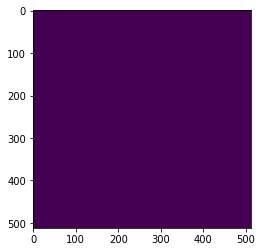

In [30]:
#Test
image,label = get_item('/content/DeepGlobe/200561_13_mask.png')

plt.imshow(label[:,:,0])

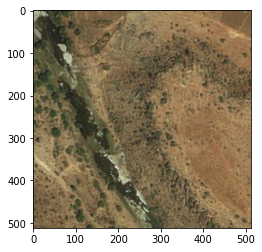

In [31]:
plt.imshow(image/255)

In [32]:
np.unique(label) #water,barren and forest

array([6.], dtype=float32)

In [33]:
train_ds = list_ds.map(get_item,num_parallel_calls=tf.data.AUTOTUNE)
for f in train_ds.take(2):
  print(f[0].shape,f[1].shape)
  test_data = f

(512, 512, 3) (512, 512, 1)
(512, 512, 3) (512, 512, 1)


In [34]:
train_ds = train_ds.batch(32)
test_ds = train_ds.take(1)

In [45]:
prediction = test.predict(test_ds)
prediction.shape

(32, 512, 512, 7)

In [ ]:
test.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['mae'])

##Testing over

In [20]:
data_dir = "/content/DeepGlobe"
list_ds = tf.data.Dataset.list_files(str(data_dir+"/*_sat.jpg"),shuffle=False) #DO NOT SHUFFLE
#dataset is made up of strings

In [47]:
def preprocessing(list_ds,batch_size=8,augmentation=None):
  ds = list_ds.map(get_item,num_parallel_calls=tf.data.AUTOTUNE) #(h,w,3),(h,w,1)
  ds = ds.shuffle(100)

  if augmentation:
    ds = ds.map((lambda x,y : augmentation(x,y)),num_parallel_calls=tf.data.AUTOTUNE)

  ds = ds.batch(batch_size)
  ds = ds.prefetch(8)
  return ds

def transform(x,y):
  """
  Write your data transformations here
  """
  x=tf.keras.layers.experimental.preprocessing.Rescaling(1./255.0)(x)
  y=tf.one_hot(tf.cast(y[:,:,0],dtype = tf.int32),depth = 7)

  return x,y

In [48]:
ds = preprocessing(list_ds,augmentation=transform)

#Model.fit() crashes due to memory issues, cannot load the whole dataset into memory?

In [49]:
#test.fit(ds,epochs=2,verbose=1)

In [50]:
model_savename = "vgg_512_seg_model"

In [51]:
test_element = list(ds.take(1))[0]

In [52]:
x_batch,y_batch = test_element

In [60]:
loss_function = tf.keras.losses.CategoricalCrossentropy(from_logits=True)#adds a softmax step

train_accuracy = tf.keras.metrics.CategoricalAccuracy(
        name='train_accuracy')

learning_rate = 0.003 #use custom schedule here

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                         epsilon=1e-9)

In [61]:
y_pred = test(x_batch)

In [62]:
loss_value = loss_function(y_pred, y_batch)

In [63]:
save_path = "/content/Saved_Models"
if not(os.path.isdir(save_path)):
  os.mkdir(save_path)

In [64]:
train_accuracy(y_pred,y_batch)

<tf.Tensor: shape=(), dtype=float32, numpy=0.12440634>

In [66]:
epochs = 2
for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))

    # Iterate over the batches of the dataset.
    for step, (x_batch,y_batch) in enumerate(ds):


        with tf.GradientTape() as tape: #records operation on forward pass to prepare for gradient computation

            y_pred = test(x_batch, training=True)  #forward pass

            loss_value = loss_function(y_batch, y_pred) #loss value

        grads = tape.gradient(loss_value, test.trainable_weights) #use tape.gradient() to retrieve the gradient

        optimizer.apply_gradients(zip(grads, test.trainable_weights)) #optimize the weights

        # Log every 100 batches.
        if step % 100 == 0:
            print(
                "Training loss (for one batch) at step %d: %.4f"
                % (step, float(loss_value))
            )
            acc = train_accuracy(y_pred,y_batch)
            print ("Training accuracy at step {} is {}".format(step, acc))
            print("Seen so far: %s samples" % ((step + 1) * 8))
            
    test.save('saved_model/{}'.format(model_savename))


Start of epoch 0
Training loss (for one batch) at step 0: 1.6584
Training accuracy at step 0 is 0.22461239993572235
Seen so far: 8 samples
Training loss (for one batch) at step 100: 1.6706
Training accuracy at step 100 is 0.2936455011367798
Seen so far: 808 samples
Training loss (for one batch) at step 200: 1.4839
Training accuracy at step 200 is 0.34654664993286133
Seen so far: 1608 samples
Training loss (for one batch) at step 300: 1.5327
Training accuracy at step 300 is 0.37155404686927795
Seen so far: 2408 samples
Training loss (for one batch) at step 400: 0.9967
Training accuracy at step 400 is 0.4239845275878906
Seen so far: 3208 samples
Training loss (for one batch) at step 500: 0.9464
Training accuracy at step 500 is 0.47043341398239136
Seen so far: 4008 samples
Training loss (for one batch) at step 600: 1.5510
Training accuracy at step 600 is 0.45956331491470337
Seen so far: 4808 samples
Training loss (for one batch) at step 700: 1.0884
Training accuracy at step 700 is 0.4860

In [67]:
shutil.make_archive("/content/vgg_512_seg_model",'zip',"/content/saved_model/vgg_512_seg_model")


'/content/vgg_512_seg_model.zip'

In [68]:
shutil.copy2("/content/vgg_512_seg_model.zip","/content/drive/MyDrive")

'/content/drive/MyDrive/vgg_512_seg_model.zip'